# Statistical Physics

## Exercise 1.2.6

Import relevant packages

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook # Progress bar for loops

# Import user written module
import ising

%matplotlib inline

# Ensure to reload the module whenever it is updated
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some description of the Ising model and the Metropolis Hastings algorithm

Define parameter values - maybe move

In [117]:
N = 80
n_max = 5000
n_0 = 2000

Create and plot and initial state for visualization

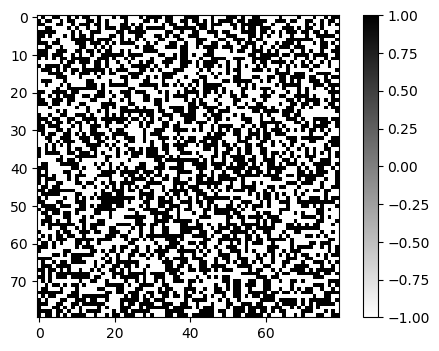

In [108]:
# Define initial state
config = ising.initialstate(N)

# Test plot
plt.figure(dpi=100)
plt.imshow(config, cmap='binary')
plt.colorbar()

Run the Metroplis-Hastings algorithm for the Ising model.
For each Monte Carlo step, I save the resulting average energy and magnetization per site.

In [120]:
# Initialize
config = ising.initialstate(N)
energy_vec = np.empty(n_max)
mag_vec = np.empty(n_max)
beta = 0.1

# Perform n_max Monte Carlo steps
for i in range(n_max) :
    
    # Energy per site and average magnetization
    energy_vec[i] = ising.calcEnergy(config)
    mag_vec[i] = ising.calcMag(config)
    
    # Perform MC move
    ising.mcmove(config, beta)

Plot the resulting lattice

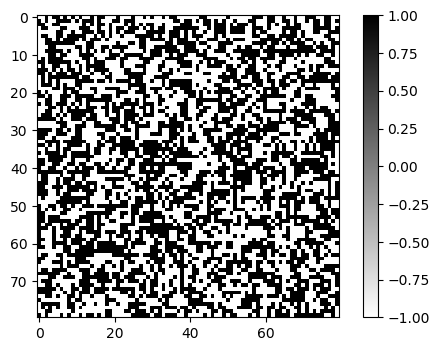

In [121]:
plt.figure(dpi=100)
plt.imshow(config, cmap='binary')
plt.colorbar()
plt.show()

Plot average energy and magnetization is a function of the iteration number

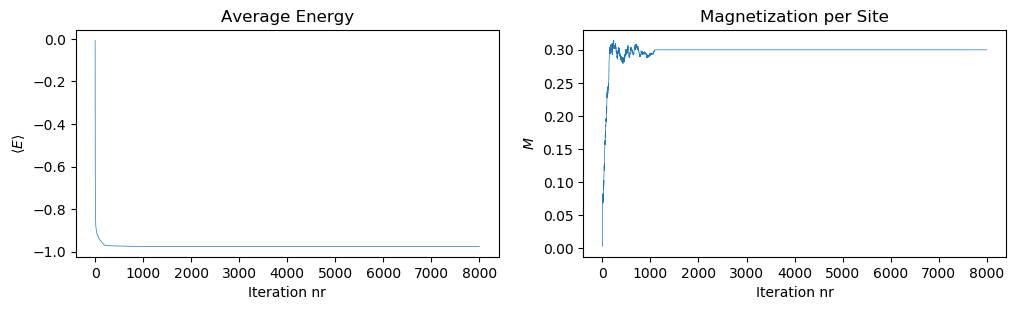

In [111]:
# Initialize figure
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,3),dpi=100)

# Energy 
ax1.plot(energy_vec, linewidth = 0.5)
ax1.set_title('Average Energy')
ax1.set_xlabel('Iteration nr')
ax1.set_ylabel('$\\langle E \\rangle$')

# Magnetization
ax2.plot(mag_vec, linewidth = 0.5)
ax2.set_title('Magnetization per Site')
ax2.set_ylabel('$M$')
ax2.set_xlabel('Iteration nr')

plt.show()

Compute internal energy $\langle E \rangle$ and magnetization per site $\langle s \rangle$ as a function of $k_B T = \beta^{-1}$.

In [9]:
################
## Initialize ##
################

kbT_vec = np.linspace(0.5, 3.5, 20) # Vector of values of inverse beta
energy_vec_kbT = np.empty(len(kbT_vec))
mag_vec_kbT = np.empty(len(kbT_vec))
repetitions = 5

#####################
## Run Monte Carlo ##
#####################

for i,kbT in enumerate(kbT_vec):

    # Initialize
    config = ising.initialstate(N)
    mag_temp = np.zeros(n_max - n_0 - 1) + np.nan

    # Beta is the inverse temperature
    beta_val = 1.0/kbT

    # run MC-MC
    for it in range(n_max):

        # Run Monte Carlo
        ising.mcmove(config, beta_val)

        # Begin to store data after n0 mc steps
        if it > n_0:
            mag_temp[it - n_0 - 1] = config.mean()

    # Save the resulting energy and magnetization
    mag_vec_kbT[i] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

Plot the results and compare with Onsagers exact solution

In [10]:
# Compute function of Onsager's solution
x_onsager = np.linspace(0.5, 2.2691853, 200) # Check these values out
y_onsager = (1 - np.sinh(2 / x_onsager)**(-4))**(1/8)

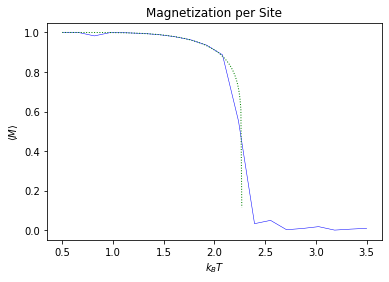

In [18]:
# Initialize figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# ax.scatter(kbT_vec, mag_vec_kbT, color = '0.3', s = 10)
ax.plot(kbT_vec, mag_vec_kbT, linewidth = 0.5, color = 'blue', linestyle = '-')
ax.plot(x_onsager, y_onsager, linewidth = 1, color = 'green', linestyle = ':')
ax.set_title('Magnetization per Site')
ax.set_xlabel('$k_B T$')
ax.set_ylabel('$\\langle M \\rangle$')

plt.show()

Try to determine $\beta$ around $k_BT \sim 2.2$ numerically

Consider writing the below code as a function instead.

I solve this by simulating the model in the area around the critical point $T = T_c$. 
Theory tells that $\log |M| \propto (-t)^\beta$ where $t = \frac{T- T_c}{T_c}$ is the temperature relative to the critical temperature.

The critical exponent can therefore be estimated by the equation
$$ \log |M| = \alpha +  \beta \log(-t) + \varepsilon $$
using OLS.

In [142]:
################
## Initialize ##
################

kbT_vec_2 = np.linspace(2.2, 2.35, 50) # Vector of values of inverse beta
energy_vec_kbT_2 = np.empty(len(kbT_vec_2))
mag_vec_kbT_2 = np.empty(len(kbT_vec_2))

#####################
## Run Monte Carlo ##
#####################

for i,kbT in enumerate(kbT_vec_2):
    
    # Specify system size here
    N = 80

    # Initialize
    config = ising.initialstate(N)
    mag_temp = np.zeros(n_max - n_0 - 1) + np.nan

    # Beta is the inverse temperature
    beta_val = 1.0/kbT

    # run MC-MC
    for it in range(n_max):

        # Run Monte Carlo
        ising.mcmove(config, beta_val)

        # Begin to store data after n0 mc steps
        if it > n_0:
            mag_temp[it - n_0 - 1] = config.mean()

    # Save the resulting energy and magnetization
    mag_vec_kbT_2[i] = np.abs(np.mean(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

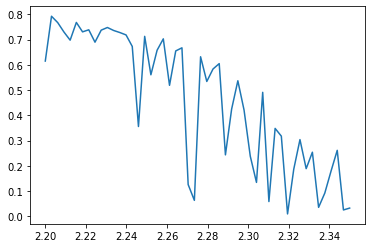

In [144]:
nr = 0
plt.plot(kbT_vec_2, mag_vec_kbT_2)

Then estimate ovre the region $T \in (2.25 , 2.3) $.
I assume $T_c = 2.3$

In [157]:
# Relative temperature
T_c = 2.35 + 10e-5
T_vec = kbT_vec_2
t_vec = (T_vec - T_c) / T_c

In [170]:
# Estimate
log_t = np.log(-t_vec)
log_M = np.log(mag_vec_kbT_2)

# Estimate the coefficient using OLS
beta_1 = np.cov(log_M,-log_t)[1,0] / np.var(-log_t)
beta_0 = np.mean(log_M - beta*(-log_t))

# Fitted values
fitted = beta_0 + beta_1*(-log_t)

Plot the results

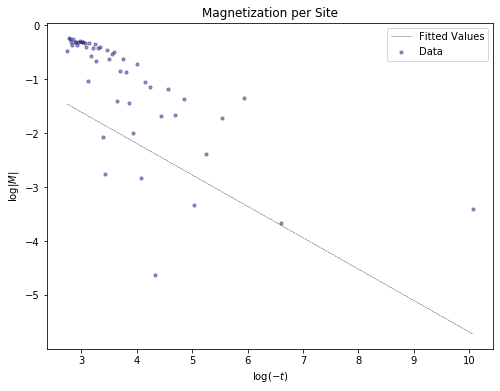

In [186]:
# Initialize figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(-log_t, log_M, color = 'blue', alpha = 0.4, edgecolor = 'k',  s = 10, label = 'Data')
ax.plot(-log_t, fitted, linewidth = 0.5, color = '0.2', linestyle = '--', label = 'Fitted Values')
ax.set_title('Magnetization per Site')
ax.set_xlabel('$\log(-t)$')
ax.set_ylabel('$ \log |M|$')

ax.legend()

plt.show()

In [187]:
print('The value of beta is ' + str(beta_0) + ' the true value is ' + str(1/8))

The value of beta is 0.1367633017051512 the true value is 0.125
